In [1]:
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline

import theano.tensor as tt
import pymc3 as pm

import exoplanet as xo
import specgp as sgp

red = '#FE4365'
blue = '#00A9FF'
yellow = '#ECA25C'
green = '#3F9778'
darkblue = '#005D7F'
colors = [red, green, blue, yellow, darkblue]

In [2]:
with pm.Model() as model:
    trace = pm.load_trace('traces/trace3')
    mu, sig = {}, {}
    for k, v in trace[0].items():
        vals = trace.get_values(k)
        mu[k] = np.mean(vals, axis=0)
        sig[k] = np.std(vals, axis=0)
        
ppm = np.array([20, 20, 20])
mu['logsig'] = np.log(ppm * 1e-3)

In [3]:
from astropy.io import fits
from astropy.time import Time

blue = fits.open('soho/blue.fits')
green = fits.open('soho/green.fits')
red = fits.open('soho/red.fits')
rgb = red, green, blue

rgb = [f[0].data for f in rgb]
mask = np.all([np.isfinite(f) for f in rgb], axis=0)

start = blue[0].header['DATES'][0:9]
end = blue[0].header['DATES'][14:]
start, end = Time([start, end]).jd
t = np.linspace(start, end, np.shape(rgb)[1]) - start

t = t[mask]
rgb = [f[mask].astype('float64') for f in rgb]
flux = np.sum(rgb, axis=0)/np.shape(rgb)[0]

# choose an arbitrary starting index and number of points to 
# select a segment of the (very large) SOHO timeseries 
i = 909091
n = 2000
t = t[i:i+n] - np.mean(t[i:i+n])
# in units of parts per thousand 
rgb = [f[i:i+n]/1e3 for f in rgb]

# add artificial white noise to the SOHO data in order 
# to make the model numerically stable.
rgb += np.random.randn(3, n) * 20 * 1e-3
r, g, b = rgb

In [4]:
#rm = 0.003 + np.random.rand() * 0.005
rm = 0.004
tm = -0.4 + np.random.rand() * 0.8
#tm = 0.3
np.savetxt("input.dat", (rm, tm))
print(tm)

0.06553440704036645


In [5]:
orbit = xo.orbits.KeplerianOrbit(period=5.0)
u = [0.3, 0.2]
planet = (
    xo.LimbDarkLightCurve(u)
    .get_light_curve(orbit=orbit, r=0.01, t=t, texp=0.02)
    .eval()
).T[0] * 1e3
moon = (
    xo.LimbDarkLightCurve(u)
    .get_light_curve(orbit=orbit, r=rm , t=t-tm, texp=0.02)
    .eval()
).T[0] * 1e3

/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `ar

[Text(0.5, 0, 'time (days)'), Text(0.5, 0, 'time (days)')]

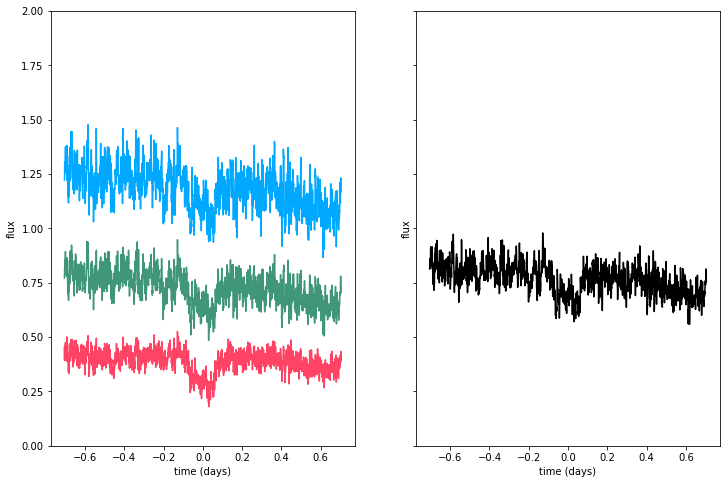

In [6]:
fig, ax = pl.subplots(1, 2, figsize=(12, 8), sharey=True)

ax[0].plot(t, r+0.5 + planet + moon, '-', color=colors[0])
ax[0].plot(t, g+1 + planet + moon, '-', color=colors[1])
ax[0].plot(t, b+1.5 + planet + moon, '-', color=colors[2])
ax[0].set_ylim(-1, 3)

ax[1].plot(t, np.mean([r, g, b], axis=0)+1 + planet, '-', color='k')
ax[1].set_ylim(0.0, 2.0)

[x.set_ylabel('flux') for x in ax]
[x.set_xlabel('time (days)') for x in ax]

In [7]:
mean = planet + moon
mean = np.tile(mean, (3, 1))
obs = rgb + mean
obs = np.reshape(obs.T, (3*len(t)))

def getmodel(holds={}, transform=False):
    
    params = ['logS0', 'logw', 'logQ', 'alpha1', 'alpha2', 
             'logsig', 'mean', 'u', 'logrp', 'logrm', 't0p', 't0m']
    for p in params:
        if p not in holds:
            holds[p] = None
    
    with pm.Model() as model:
        logS0 = pm.MvNormal("logS0", mu=mu["logS0"], 
                        chol=np.diag(sig["logS0"]), shape=2, observed=holds['logS0'])
        logw = pm.MvNormal("logw", mu=mu["logw"], 
                       chol=np.diag(sig["logw"]), shape=2, observed=holds['logw'])
        logQ = pm.Normal("logQ", mu=mu["logQ"], sd=sig["logQ"], observed=holds['logQ'])
        alpha1 =  pm.MvNormal("alpha1", mu=mu["alpha1"], 
                          chol=np.diag(sig["alpha1"]), shape=2, observed=holds['alpha1'])
        alpha2 =  pm.MvNormal("alpha2", mu=mu["alpha2"], 
                          chol=np.diag(sig["alpha2"]), shape=2, observed=holds['alpha2'])
        logsig = pm.MvNormal("logsig", mu=mu["logsig"], 
                         chol=np.diag(sig["logsig"]), shape=3, observed=holds['logsig'])
        mean = pm.MvNormal("mean", mu=mu["mean"], 
                       chol=np.diag(sig["mean"]), shape=3, observed=holds['mean'])
        u = sgp.distributions.MvUniform("u", lower=[0, 0], upper=[1, 1], 
                                        testval=[0.5, 0.5], observed=holds['u'])
        
        if transform:
            logrp = pm.Uniform("logrp", lower=-20.0, upper=0.0, testval=np.log(0.01), 
                               observed=holds['logrp'])
            logrm = pm.Uniform("logrm", lower=-20.0, upper=0.0, testval=np.log(0.002), 
                               observed=holds['logrm'])
            t0p = pm.Uniform("t0p", lower=-1, upper=1, testval=0.0, 
                             observed=holds['t0p'])
            t0m = pm.Uniform("t0m", lower=-1, upper=1, testval=0.0, 
                             observed=holds['t0m'])
        else:
            logrp = pm.Uniform("logrp", lower=-20.0, upper=0.0, testval=np.log(0.01), 
                           transform=None, observed=holds['logrp'])
            logrm = pm.Uniform("logrm", lower=-20.0, upper=0.0, testval=np.log(0.004), 
                           transform=None, observed=holds['logrm'])
            t0p = pm.Uniform("t0p", lower=-1, upper=1, testval=0.0, 
                         transform=None, observed=holds['t0p'])
            t0m = pm.Uniform("t0m", lower=-1, upper=1, testval=0.0, 
                         transform=None, observed=holds['t0m'])
        
        orbit = xo.orbits.KeplerianOrbit(period=5.0)
        lcm = (xo.LimbDarkLightCurve(model.u)
              .get_light_curve(orbit=orbit, r=np.exp(logrm), t=t-t0m, texp=0.02)
              *1e3)
        lcp = (xo.LimbDarkLightCurve(model.u)
              .get_light_curve(orbit=orbit, r=np.exp(logrp), t=t-t0p, texp=0.02)
              *1e3)
        mean = mean[:, None] + lcm.T[0] + lcp.T[0]
    
        term1 = xo.gp.terms.SHOTerm(
                log_S0 = logS0[0],
                log_w0 = logw[0],
                log_Q = -np.log(np.sqrt(2))
            )
        term2 = xo.gp.terms.SHOTerm(
                log_S0 = logS0[1],
                log_w0 = logw[1],
                log_Q = logQ
            )
        
        a1 = tt.exp(tt.stack([0.0, alpha1[0], alpha2[0]]))
        a2 = tt.exp(tt.stack([0.0, alpha1[1], alpha2[1]]))
        
        kernel = (sgp.terms.KronTerm(term1, alpha=a1) + 
                  sgp.terms.KronTerm(term2, alpha=a2))
        
        yerr = tt.exp(2 * logsig)
        yerr = yerr[:, None] * tt.ones(len(t))
        
        gp = xo.gp.GP(kernel, t, yerr, J=4, mean=sgp.means.KronMean(mean))
        marg = gp.marginal("gp", observed = obs.T)
    return model

In [8]:
m = getmodel()
with m:
    map_soln = xo.optimize(start=m.test_point, verbose=True)

/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
optimizing logp for variables: [t0m, t0p, logrm, logrp, u, mean, logsig, alpha2, alpha1, logQ, logw, logS0]


/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `ar

/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: -31175.608593423676 -> 14703.789892671848


In [9]:
import copy
holds = copy.deepcopy(map_soln)
holds.pop('logrm')
a1start = holds.pop('alpha1')
a2start = holds.pop('alpha2')
meanstart = holds.pop('mean')
logsigstart = holds.pop('logsig')
holds['logrp'] = np.log(0.01)
holds['t0p'] = 0.0

start = {
    "logrm": np.log(0.002),
    "alpha1": a1start,
    "alpha2": a2start,
    "mean": meanstart,
    "logsig": logsigstart
}

t0grid = np.linspace(-0.6, 0.6, 50)
ll = np.zeros_like(t0grid)
lr = np.zeros_like(t0grid)
for i, t0 in enumerate(t0grid):
    holds['t0m'] = t0
    m = getmodel(holds)
    with m:
        print('\r{0}/{1}'.format(i+1, len(t0grid)), end='')
        newmap_soln = xo.optimize(start=start, verbose=True)
        lr[i] = newmap_soln['logrm']
        ll[i] = m.logp(newmap_soln)

/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


1/50

optimizing logp for variables: [logrm, mean, logsig, alpha2, alpha1]


/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `ar

/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


2/50

optimizing logp for variables: [logrm, mean, logsig, alpha2, alpha1]


/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 14702.525527309734 -> 14702.806637433056


/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


3/50

optimizing logp for variables: [logrm, mean, logsig, alpha2, alpha1]


/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 14704.011455560325 -> 14704.367511578334


/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


4/50

optimizing logp for variables: [logrm, mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14707.754128409204 -> 14712.506603444232


5/50

optimizing logp for variables: [logrm, mean, logsig, alpha2, alpha1]


/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `ar

/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


6/50

optimizing logp for variables: [logrm, mean, logsig, alpha2, alpha1]


/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 14712.296167550083 -> 14730.54925605077


/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


7/50

optimizing logp for variables: [logrm, mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14711.93302608439 -> 14728.419808023573


8/50

optimizing logp for variables: [logrm, mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14710.188246962029 -> 14720.802181609934


9/50

optimizing logp for variables: [logrm, mean, logsig, alpha2, alpha1]


/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Optimization terminated successfully.
logp: 14707.861626439995 -> 14712.62527942004



10/50

optimizing logp for variables: [logrm, mean, logsig, alpha2, alpha1]


/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 14705.16164467867 -> 14706.172441698238


/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


11/50

optimizing logp for variables: [logrm, mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14704.29277349302 -> 14704.750172690596


12/50

optimizing logp for variables: [logrm, mean, logsig, alpha2, alpha1]


/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 14704.356066391312 -> 14704.845824407843


/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


13/50

optimizing logp for variables: [logrm, mean, logsig, alpha2, alpha1]


/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `ar

/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


14/50

optimizing logp for variables: [logrm, mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14699.950255726919 -> 14702.172551546966


15/50

optimizing logp for variables: [logrm, mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14698.439609551357 -> 14702.17255153354


16/50

optimizing logp for variables: [logrm, mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14696.041172862997 -> 14702.172551522175


17/50

optimizing logp for variables: [logrm, mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14693.607693602837 -> 14702.17255150901


18/50

optimizing logp for variables: [logrm, mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14692.738135878497 -> 14702.172551486452


19/50

optimizing logp for variables: [logrm, mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14692.931563136402 -> 14702.17255148888


20/50

optimizing logp for variables: [logrm, mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14693.146461866882 -> 14702.172551480446


21/50

optimizing logp for variables: [logrm, mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14694.051892308285 -> 14702.172551504611


22/50

optimizing logp for variables: [logrm, mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14694.756669720895 -> 14702.172551518535


23/50

optimizing logp for variables: [logrm, mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14696.356728054585 -> 14702.172551519587


24/50

optimizing logp for variables: [logrm, mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14697.561824664463 -> 14702.172551530102


25/50

optimizing logp for variables: [logrm, mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14699.725743417523 -> 14702.172551542144


26/50

optimizing logp for variables: [logrm, mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14700.682792526195 -> 14702.172551550651


27/50

optimizing logp for variables: [logrm, mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14703.137090792236 -> 14703.34585467726


28/50

optimizing logp for variables: [logrm, mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14703.962098581824 -> 14704.304124912314



29/50

optimizing logp for variables: [logrm, mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14702.308821707262 -> 14702.66860295489


30/50

optimizing logp for variables: [logrm, mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14699.35334034169 -> 14702.172551544378


31/50

optimizing logp for variables: [logrm, mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14696.982971862713 -> 14702.172551521828


32/50

optimizing logp for variables: [logrm, mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14693.884554672117 -> 14702.172551496298


33/50

optimizing logp for variables: [logrm, mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14690.166604655931 -> 14702.172551495501


34/50

optimizing logp for variables: [logrm, mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14689.533161188378 -> 14702.172551479658


35/50

optimizing logp for variables: [logrm, mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14688.976203796346 -> 14702.172551451424


36/50

optimizing logp for variables: [logrm, mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14688.15880448665 -> 14702.172551435933


37/50

optimizing logp for variables: [logrm, mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14687.61405507753 -> 14702.172551443586


38/50

optimizing logp for variables: [logrm, mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14688.375166803065 -> 14702.17255148791


39/50

optimizing logp for variables: [logrm, mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14689.337224543075 -> 14702.172551481182


40/50

optimizing logp for variables: [logrm, mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14690.661352945088 -> 14702.172551483909


41/50

optimizing logp for variables: [logrm, mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14691.469508766051 -> 14702.172551485495


42/50

optimizing logp for variables: [logrm, mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14691.865069962929 -> 14702.172551496857


43/50

optimizing logp for variables: [logrm, mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14692.423958647643 -> 14702.172551507236


44/50

optimizing logp for variables: [logrm, mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14693.984370465276 -> 14702.172551499698


45/50

optimizing logp for variables: [logrm, mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14695.82594058946 -> 14702.172551526688


46/50

optimizing logp for variables: [logrm, mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14697.806782614005 -> 14702.172551528729


47/50

optimizing logp for variables: [logrm, mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14699.702118382436 -> 14702.172551544201


48/50

optimizing logp for variables: [logrm, mean, logsig, alpha2, alpha1]


/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Desired error not necessarily achieved due to precision loss.
logp: 14701.897760328406 -> 14702.456667345648


/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


49/50

optimizing logp for variables: [logrm, mean, logsig, alpha2, alpha1]


/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `ar

/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


50/50

optimizing logp for variables: [logrm, mean, logsig, alpha2, alpha1]


/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
message: Optimization terminated successfully.
logp: 14702.66970551774 -> 14702.947596416841


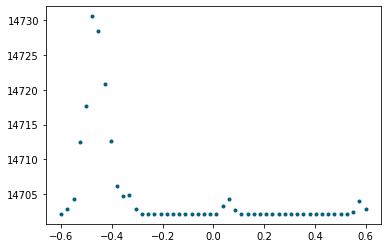

In [10]:
pl.plot(t0grid, ll, '.', color=darkblue)

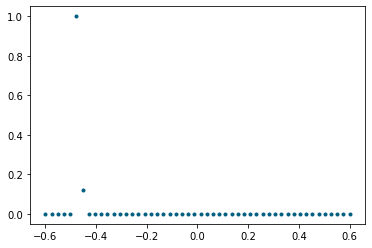

In [11]:
pl.plot(t0grid, np.exp(ll - np.max(ll)), '.', color=darkblue)

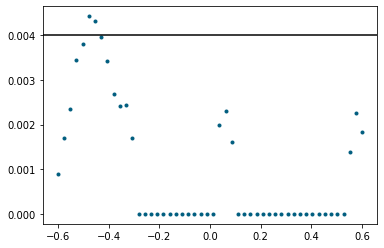

In [12]:
pl.plot(t0grid, np.exp(lr), '.', color=darkblue)
pl.axhline(0.004, color='k')

In [13]:
from scipy.signal import find_peaks
p, res = find_peaks(ll, prominence=10)
t0grid[p]

array([-0.47755102])

[(-0.6, 0.6), (-0.6, 0.6)]

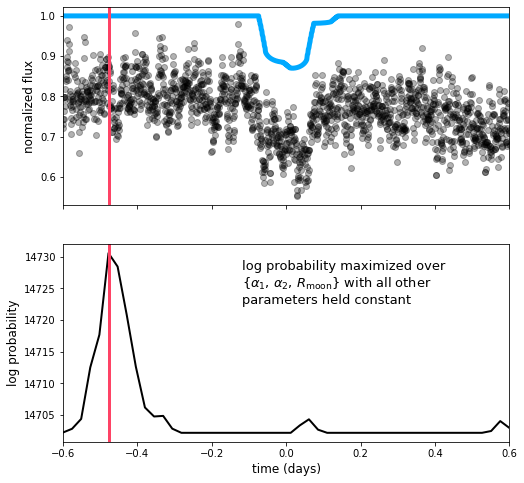

In [14]:
fig, axs = pl.subplots(2, 1, figsize=(8, 8), sharex=True)
axs[0].plot(t, np.mean([r, g, b], axis=0) + planet+moon + 1, 'o', color='k', alpha=0.3)
axs[0].plot(t, planet+moon + 1, color=colors[2], linewidth=5)
axs[0].set_ylabel("normalized flux", fontsize=12)

axs[1].plot(t0grid, ll, color='k', linewidth=2)
axs[1].set_ylabel("log probability", fontsize=12)
axs[1].set_xlabel("time (days)", fontsize=12)
axs[1].annotate("log probability maximized over " + "\n"
                + r"{$\alpha_1$, $\alpha_2$, $R_\mathrm{moon}$} with all other" 
                + "\n" + 
                "parameters held constant", xy=(0.4, 0.7), xycoords='axes fraction', 
               fontsize=13)

[[ax.axvline(t0grid[p], color=colors[0], linewidth=3) for p in p] for ax in axs]
[ax.set_xlim(-0.6, 0.6) for ax in axs]

[(-0.6, 0.6), (-0.6, 0.6)]

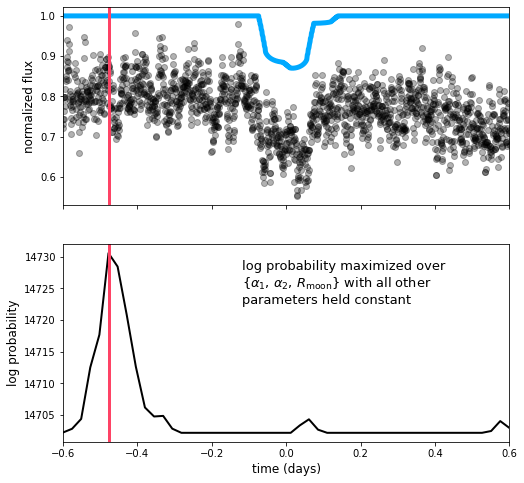

In [15]:
fig, axs = pl.subplots(2, 1, figsize=(8, 8), sharex=True)
axs[0].plot(t, np.mean([r, g, b], axis=0) + planet+moon + 1, 'o', color='k', alpha=0.3)
axs[0].plot(t, planet+moon + 1, color=colors[2], linewidth=5)
axs[0].set_ylabel("normalized flux", fontsize=12)

axs[1].plot(t0grid, ll, color='k', linewidth=2)
axs[1].set_ylabel("log probability", fontsize=12)
axs[1].set_xlabel("time (days)", fontsize=12)
axs[1].annotate("log probability maximized over " + "\n"
                + r"{$\alpha_1$, $\alpha_2$, $R_\mathrm{moon}$} with all other" 
                + "\n" + 
                "parameters held constant", xy=(0.4, 0.7), xycoords='axes fraction', 
               fontsize=13)

[[ax.axvline(t0grid[p], color=colors[0], linewidth=3) for p in p] for ax in axs]
[ax.set_xlim(-0.6, 0.6) for ax in axs]

In [16]:
import copy
holds = copy.deepcopy(map_soln)
holds.pop('logrm')
a1start = holds.pop('alpha1')
a2start = holds.pop('alpha2')
meanstart = holds.pop('mean')
logsigstart = holds.pop('logsig')
holds['logrp'] = np.log(0.01)
holds['t0p'] = 0.0

start = {
    "t0m": 0.0655,
    "alpha1": a1start,
    "alpha2": a2start,
    "mean": meanstart,
    "logsig": logsigstart
}

rmgrid = np.linspace(0.00, 0.006, 50)
ll = np.zeros_like(rmgrid)
lr = np.zeros_like(rmgrid)
for i, rm in enumerate(rmgrid):
    holds['logrm'] = np.log(rm)
    m = getmodel(holds)
    with m:
        print('\r{0}/{1}'.format(i+1, len(rmgrid)), end='')
        newmap_soln = xo.optimize(start=start, verbose=True)
        ll[i] = m.logp(newmap_soln)

/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


1/50

optimizing logp for variables: [mean, logsig, alpha2, alpha1]


message: Desired error not necessarily achieved due to precision loss.
logp: -inf -> -inf
final logp not finite, returning initial point
this suggests that something is wrong with the model



2/50

optimizing logp for variables: [mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14702.134642582945 -> 14702.149121076807



3/50

optimizing logp for variables: [mean, logsig, alpha2, alpha1]


message: Desired error not necessarily achieved due to precision loss.
logp: 14702.063269055388 -> 14702.078623127287
/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


4/50

optimizing logp for variables: [mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14701.94355250661 -> 14701.960433988796



5/50

optimizing logp for variables: [mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14701.774280960635 -> 14701.793444221745



6/50

optimizing logp for variables: [mean, logsig, alpha2, alpha1]


message: Desired error not necessarily achieved due to precision loss.
logp: 14701.553864242936 -> 14701.576207384465
/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


7/50

optimizing logp for variables: [mean, logsig, alpha2, alpha1]


message: Desired error not necessarily achieved due to precision loss.
logp: 14701.280238273155 -> 14701.306844439649
/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


8/50

optimizing logp for variables: [mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14700.950896776736 -> 14700.983076063098



9/50

optimizing logp for variables: [mean, logsig, alpha2, alpha1]


message: Desired error not necessarily achieved due to precision loss.
logp: 14700.562896680322 -> 14700.602228767699
/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


10/50

optimizing logp for variables: [mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14700.112838169409 -> 14700.161215813485



11/50

optimizing logp for variables: [mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14699.596864726615 -> 14699.656537843573



12/50

optimizing logp for variables: [mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14699.01066519819 -> 14699.084286068333



13/50

optimizing logp for variables: [mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14698.34947417777 -> 14698.440143943419



14/50

optimizing logp for variables: [mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14697.607856557142 -> 14697.719174080486


15/50

optimizing logp for variables: [mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14696.780144800361 -> 14696.916255929427



16/50

optimizing logp for variables: [mean, logsig, alpha2, alpha1]


message: Desired error not necessarily achieved due to precision loss.
logp: 14695.860174380688 -> 14696.025823398388
/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


17/50

optimizing logp for variables: [mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14694.841290707835 -> 14695.041874873392



18/50

optimizing logp for variables: [mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14693.716538254324 -> 14693.958165738655



19/50

optimizing logp for variables: [mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14692.478452165278 -> 14692.768002560404


20/50

optimizing logp for variables: [mean, logsig, alpha2, alpha1]


message: Desired error not necessarily achieved due to precision loss.
logp: 14691.119102988147 -> 14691.464291747548
/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


21/50

optimizing logp for variables: [mean, logsig, alpha2, alpha1]


message: Desired error not necessarily achieved due to precision loss.
logp: 14689.630103161131 -> 14690.039550384052
/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


22/50

optimizing logp for variables: [mean, logsig, alpha2, alpha1]


message: Desired error not necessarily achieved due to precision loss.
logp: 14688.002609147226 -> 14688.48591327672
/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


23/50

optimizing logp for variables: [mean, logsig, alpha2, alpha1]


message: Desired error not necessarily achieved due to precision loss.
logp: 14686.227103074189 -> 14686.794922174062
/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


24/50

optimizing logp for variables: [mean, logsig, alpha2, alpha1]


message: Desired error not necessarily achieved due to precision loss.
logp: 14684.293731214453 -> 14684.957867953302
/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


25/50

optimizing logp for variables: [mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14682.192412236762 -> 14682.965903184595



26/50

optimizing logp for variables: [mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14679.912547271844 -> 14680.809761639634
/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


27/50

optimizing logp for variables: [mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14677.443018005355 -> 14678.47977052292



28/50

optimizing logp for variables: [mean, logsig, alpha2, alpha1]


message: Desired error not necessarily achieved due to precision loss.
logp: 14674.772258995583 -> 14675.96592717518
/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


29/50

optimizing logp for variables: [mean, logsig, alpha2, alpha1]


message: Desired error not necessarily achieved due to precision loss.
logp: 14671.888250742162 -> 14673.25790319803
/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


30/50

optimizing logp for variables: [mean, logsig, alpha2, alpha1]


message: Desired error not necessarily achieved due to precision loss.
logp: 14668.778519169668 -> 14670.345055393766
/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


31/50

optimizing logp for variables: [mean, logsig, alpha2, alpha1]


message: Desired error not necessarily achieved due to precision loss.
logp: 14665.430135798295 -> 14667.216438313577
/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


32/50

optimizing logp for variables: [mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14661.82974961788 -> 14663.860851489617



33/50

optimizing logp for variables: [mean, logsig, alpha2, alpha1]


message: Desired error not necessarily achieved due to precision loss.
logp: 14657.96356245908 -> 14660.266828379696
/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


34/50

optimizing logp for variables: [mean, logsig, alpha2, alpha1]


message: Desired error not necessarily achieved due to precision loss.
logp: 14653.817237290128 -> 14656.422553805329
/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


35/50

optimizing logp for variables: [mean, logsig, alpha2, alpha1]


message: Desired error not necessarily achieved due to precision loss.
logp: 14649.375942362245 -> 14652.315925100187
/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


36/50

optimizing logp for variables: [mean, logsig, alpha2, alpha1]


message: Desired error not necessarily achieved due to precision loss.
logp: 14644.62451336995 -> 14647.934747110003
/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


37/50

optimizing logp for variables: [mean, logsig, alpha2, alpha1]


message: Desired error not necessarily achieved due to precision loss.
logp: 14639.54731071742 -> 14643.266597281507
/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


38/50

optimizing logp for variables: [mean, logsig, alpha2, alpha1]


message: Desired error not necessarily achieved due to precision loss.
logp: 14634.128108647683 -> 14638.29874108782
/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


39/50

optimizing logp for variables: [mean, logsig, alpha2, alpha1]


message: Desired error not necessarily achieved due to precision loss.
logp: 14628.349984272229 -> 14633.018049787239
/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


40/50

optimizing logp for variables: [mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14622.19613024139 -> 14627.411801282644



41/50

optimizing logp for variables: [mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14615.64930064777 -> 14621.4671662409



42/50

optimizing logp for variables: [mean, logsig, alpha2, alpha1]


message: Desired error not necessarily achieved due to precision loss.
logp: 14608.691497392445 -> 14615.170941858643
/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


43/50

optimizing logp for variables: [mean, logsig, alpha2, alpha1]


message: Desired error not necessarily achieved due to precision loss.
logp: 14601.304371052865 -> 14608.509956221573
/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


44/50

optimizing logp for variables: [mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14593.469327483452 -> 14601.471196802386
/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


45/50

optimizing logp for variables: [mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14585.16702416855 -> 14594.041357205366



46/50

optimizing logp for variables: [mean, logsig, alpha2, alpha1]


message: Desired error not necessarily achieved due to precision loss.
logp: 14576.377686902297 -> 14586.207168838228
/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


47/50

optimizing logp for variables: [mean, logsig, alpha2, alpha1]


message: Optimization terminated successfully.
logp: 14567.081088226218 -> 14577.955410224893



48/50

optimizing logp for variables: [mean, logsig, alpha2, alpha1]


message: Desired error not necessarily achieved due to precision loss.
logp: 14557.256376965852 -> 14569.272780946727
/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


49/50

optimizing logp for variables: [mean, logsig, alpha2, alpha1]


message: Desired error not necessarily achieved due to precision loss.
logp: 14546.882537938596 -> 14560.146352077496
/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


50/50

optimizing logp for variables: [mean, logsig, alpha2, alpha1]


message: Desired error not necessarily achieved due to precision loss.
logp: 14535.938196213885 -> 14550.56339841091
/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


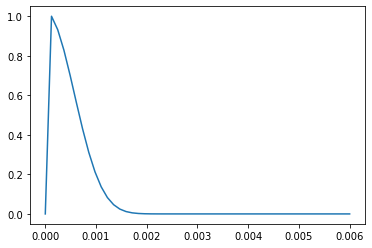

In [17]:
pl.plot(rmgrid, np.exp(ll - np.max(ll)))

In [18]:
with pm.Model() as model:
    
    logS0 = pm.MvNormal("logS0", mu=mu["logS0"], 
                        chol=np.diag(sig["logS0"]), shape=2)
    logw = pm.MvNormal("logw", mu=mu["logw"], 
                       chol=np.diag(sig["logw"]), shape=2)
    logQ = pm.Normal("logQ", mu=mu["logQ"], sd=sig["logQ"])
    alpha1 =  pm.MvNormal("alpha1", mu=mu["alpha1"], 
                          chol=np.diag(sig["alpha1"]), shape=2)
    alpha2 =  pm.MvNormal("alpha2", mu=mu["alpha2"], 
                          chol=np.diag(sig["alpha2"]), shape=2)
    logsig = pm.MvNormal("logsig", mu=mu["logsig"], 
                         chol=np.diag(sig["logsig"]), shape=3)
    mean = pm.MvNormal("mean", mu=mu["mean"], 
                       chol=np.diag(sig["mean"]), shape=3)
    u = xo.distributions.QuadLimbDark("u")
    logrp = pm.Uniform("logrp", lower=-20.0, upper=0.0, testval=np.log(0.01))
    logrm = pm.Normal("logrm", mu=np.log(0.004), sd=0.2)
    t0p = pm.Uniform("t0p", lower=-1, upper=1, testval=0.0)
    t0m = pm.Normal("t0m", mu=tm, sd=0.1)
    
    orbit = xo.orbits.KeplerianOrbit(period=5.0)
    lcm = (xo.LimbDarkLightCurve(u)
              .get_light_curve(orbit=orbit, r=np.exp(logrm), t=t-t0m, texp=0.02)
              *1e3)
    lcp = (xo.LimbDarkLightCurve(u)
              .get_light_curve(orbit=orbit, r=np.exp(logrp), t=t-t0p, texp=0.02)
              *1e3)
    mean = mean[:, None] + lcm.T[0] + lcp.T[0]
    
    term1 = xo.gp.terms.SHOTerm(
                log_S0 = logS0[0],
                log_w0 = logw[0],
                log_Q = -np.log(np.sqrt(2))
            )
    term2 = xo.gp.terms.SHOTerm(
                log_S0 = logS0[1],
                log_w0 = logw[1],
                log_Q = logQ
            )
        
    a1 = tt.exp(tt.stack([0.0, alpha1[0], alpha2[0]]))
    a2 = tt.exp(tt.stack([0.0, alpha1[1], alpha2[1]]))
    
    kernel = (sgp.terms.KronTerm(term1, alpha=a1) + 
                  sgp.terms.KronTerm(term2, alpha=a2))
        
    yerr = tt.exp(2 * logsig)
    yerr = yerr[:, None] * tt.ones(len(t))
        
    gp = xo.gp.GP(kernel, t, yerr, J=4, mean=sgp.means.KronMean(mean))
    marg = gp.marginal("gp", observed = obs.T)
    #map_soln = xo.optimize(start=model.test_point, verbose=True)
    # comment this out if you don't want to run the mcmc right now.
    trace = pm.sample(
        tune=2000,
        draws=2000,
        start=model.test_point,
        cores=2,
        chains=2,
        step=xo.get_dense_nuts_step(target_accept=0.9)
    )

/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/tgordon/Library/Python/3.7/lib/python/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [t0m, t0p, logrm, logrp, u, mean, logsig, alpha2, alpha1, logQ, logw, logS0]
Sampling 2 chains, 0 divergences:   0%|          | 0/8000 [0

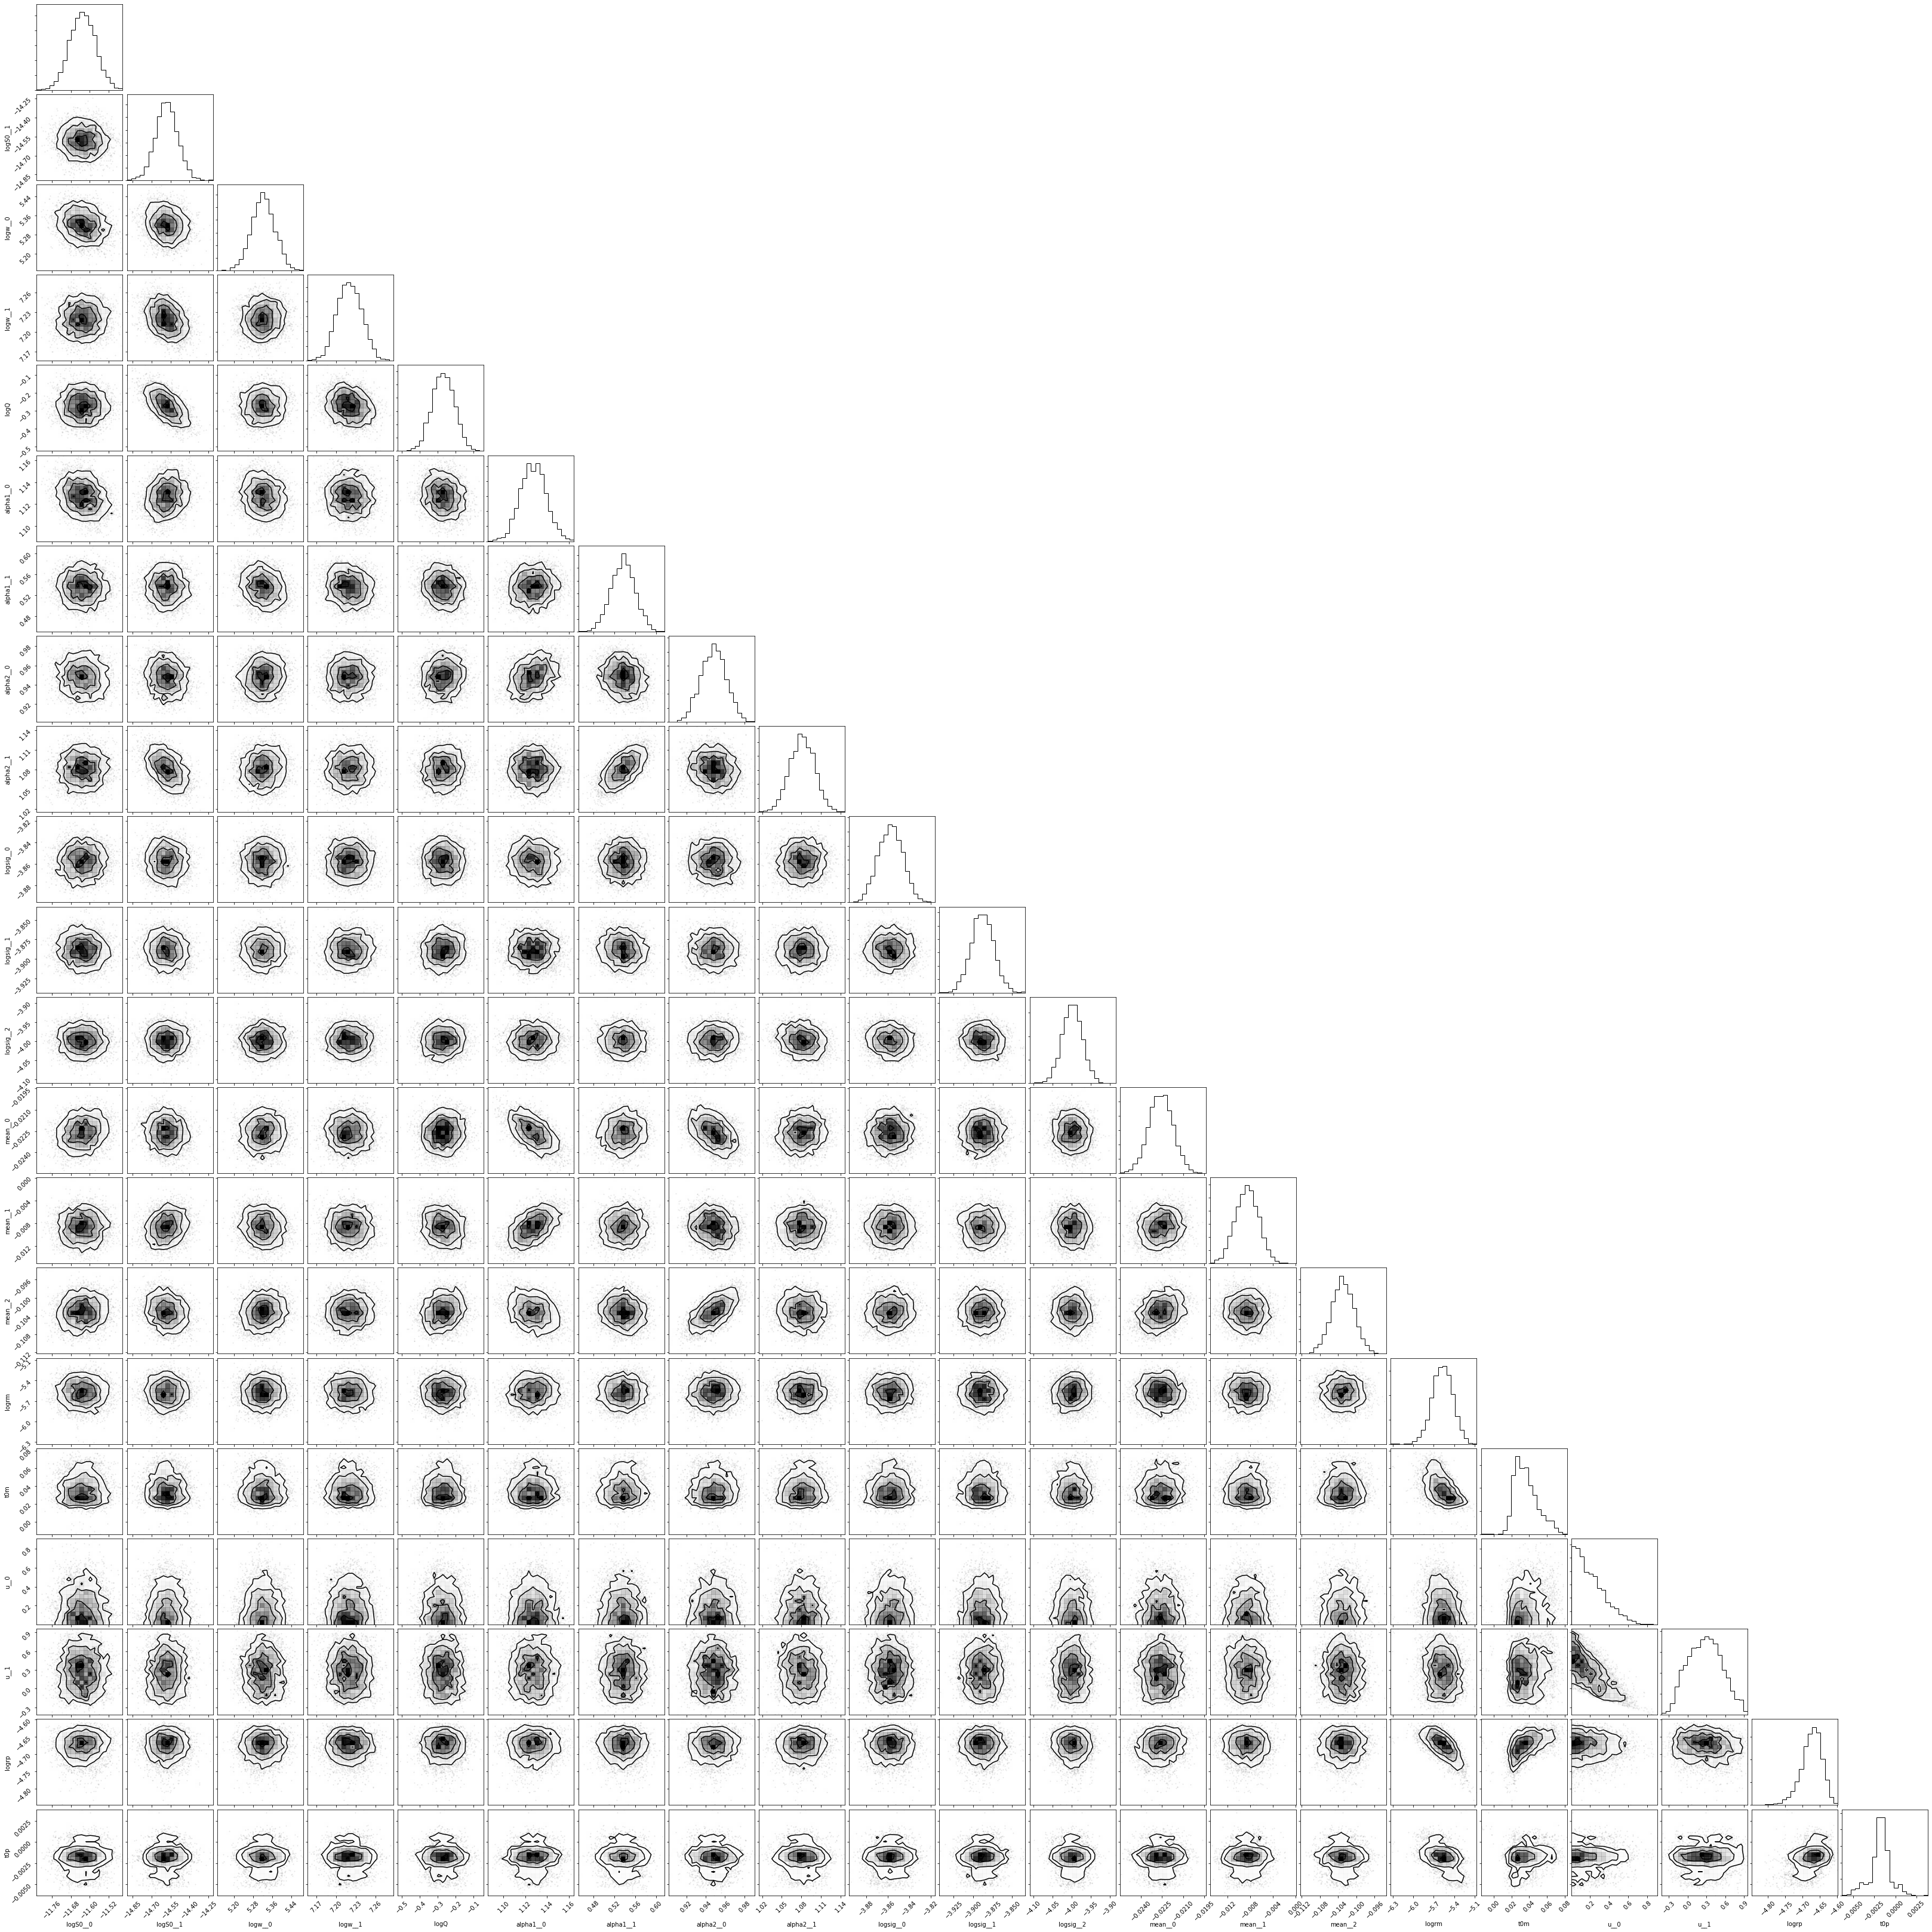

In [19]:
import corner
samples = pm.trace_to_dataframe(trace)
_ = corner.corner(samples)

In [ ]:
with model:
    trace = pm.sample(
        tune=2000,
        draws=2000,
        trace=trace,
        cores=2,
        chains=2,
        step=xo.get_dense_nuts_step(target_accept=0.9)
    )